In [126]:
%matplotlib inline
import numpy as np
import pandas as pd

from scipy import misc
import matplotlib.pyplot as plt
from skimage.transform import resize

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Dropout, Flatten, ConvLSTM2D, BatchNormalization
from keras import optimizers

In [12]:
IMAGE_PATH = 'data/images/capture/'

data = pd.DataFrame.from_csv('data/labels/rugby_image_labels_2.csv')

data.head()

,y
file_name,
1491257473.62.jpg,327.0
1491257474.29.jpg,336.0
1491257474.83.jpg,367.0
1491257475.45.jpg,392.0
1491257476.09.jpg,401.0


In [13]:
data.dropna().shape

(2828, 1)

In [14]:
test_img = misc.imread(IMAGE_PATH + data.iloc[0].name,flatten=True)

test_img.shape

(480, 640)

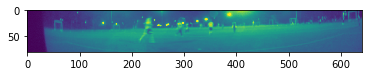

In [4]:
plt.imshow(test_img[240:320])
plt.show()

In [61]:
resize_shape = (16,50)

def my_image_resize(img):
    return resize(image=(img[240:320]/(255/2))-1, output_shape=resize_shape)

In [62]:
my_image_resize(test_img).shape

(16, 50)

In [94]:
get_rows = 2500
# get sizes of image data 
m = data.shape[0]
image_size = resize_shape#test_img.shape
# total size of numpy volume
data_size = [get_rows, *image_size]

In [95]:
# fill numpy volume with image data
data_np = np.zeros(data_size)
count = 0
prev_img = None

outputs = []

for i, v in data.iterrows():
    
    if np.isnan(v['y']):
        prev_img = None
        print('current image is none')
    else:
        
        if not(count % 100):
            print(count)

        new_img = my_image_resize(misc.imread(IMAGE_PATH + i, flatten=True))
        if prev_img is not None:
            delta_img = np.clip((prev_img - new_img),a_min=0, a_max=1)
            data_np[count,:,:] =  delta_img
            outputs.append(v['y'])
            count += 1
            if count >= get_rows:
                break
        else:
            print('prev image is none')
        prev_img = new_img
        

0
prev image is none
0
current image is none
current image is none
current image is none
current image is none
current image is none
prev image is none
current image is none
current image is none
current image is none
current image is none
current image is none
current image is none
prev image is none
current image is none
current image is none
current image is none
current image is none
current image is none
100
prev image is none
100
200
300
400
500
600
current image is none
current image is none
current image is none
current image is none
current image is none
current image is none
prev image is none
current image is none
current image is none
current image is none
current image is none
prev image is none
700
current image is none
current image is none
current image is none
current image is none
current image is none
current image is none
current image is none
current image is none
current image is none
prev image is none
current image is none
current image is none
current image is 

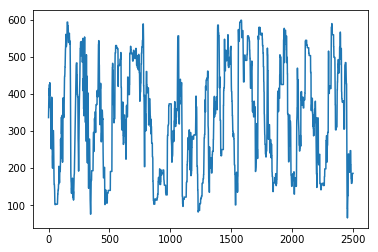

In [96]:
plt.plot( outputs)
plt.show()

## Stack images pair-wise

In [97]:
chron_X = np.zeros([data_np.shape[0]-1, 2, data_np.shape[1], data_np.shape[2]])
chron_y = np.array(outputs[1:])/640

# stack the input frames in sequencial pairs
chron_X[:,0,:,:] = data_np[:-1]
chron_X[:,1,:,:] = data_np[1:]

chron_X.shape, chron_y.shape

((2499, 2, 16, 50), (2499,))

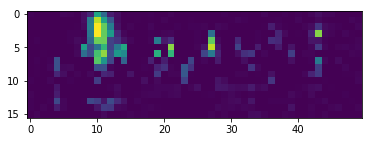

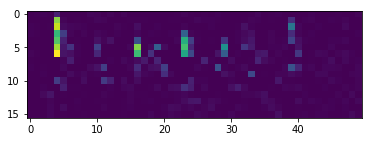

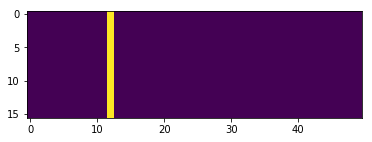

0.2515625


In [98]:
#  test some frames
i = 185

plt.imshow(chron_X[i,0,:,:])
plt.show()

plt.imshow(chron_X[i,1,:,:])
plt.show()

correct_output = np.zeros(chron_X[i,0,:,:].shape)
correct_output[:,int(correct_output.shape[1]*chron_y[i])] = 1

plt.imshow(correct_output)
plt.show()

print(chron_y[i])

In [99]:
def add_1(arr, front=False):
    if front:
        return arr.reshape([1,*arr.shape])
    
    return arr.reshape([*arr.shape,1])

In [100]:
X_train, X_test, y_train, y_test = train_test_split(
    chron_X, chron_y, test_size=0.33, random_state=42)

In [134]:
resize_shape

(16, 50)

# Define model

In [142]:
chron_model = Sequential()

chron_model.add(ConvLSTM2D(3, kernel_size=(3, 3), 
                 input_shape=(None ,*resize_shape, 1), name='input', return_sequences=True))
chron_model.add(Dropout(0.5))
# chron_model.add(BatchNormalization())
chron_model.add(ConvLSTM2D(filters=3, kernel_size=(3, 3), padding='same', name='input2'))
chron_model.add(Flatten())
chron_model.add(Dense(128, activation='relu'))
chron_model.add(Dropout(0.5))
chron_model.add(Dense(64, activation='relu'))
chron_model.add(Dense(32, activation='relu'))
# chron_model.add(Dropout(0.1))
chron_model.add(Dense(1, name='output'))

In [143]:
chron_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (ConvLSTM2D)           (None, None, 14, 48, 3)   444       
_________________________________________________________________
dropout_21 (Dropout)         (None, None, 14, 48, 3)   0         
_________________________________________________________________
input2 (ConvLSTM2D)          (None, 14, 48, 3)         660       
_________________________________________________________________
flatten_12 (Flatten)         (None, 2016)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 128)               258176    
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 64)                8256      
__________

In [144]:
chron_model.compile(loss='mean_absolute_percentage_error', optimizer='rmsprop')

In [148]:
chron_model.fit(add_1(X_train), y_train,
          batch_size=30,
          epochs=20,
          verbose=1,
          validation_data=(add_1(X_test), add_1(y_test)))

Train on 1674 samples, validate on 825 samples
Epoch 1/20
1674/1674 [==============================] - 8s 5ms/step - loss: 7.9512 - val_loss: 13.2928
Epoch 2/20
1674/1674 [==============================] - 8s 5ms/step - loss: 8.1371 - val_loss: 13.0700
Epoch 3/20
1674/1674 [==============================] - 8s 5ms/step - loss: 7.9819 - val_loss: 12.9439
Epoch 4/20
1674/1674 [==============================] - 9s 5ms/step - loss: 8.0819 - val_loss: 12.8614
Epoch 5/20
1674/1674 [==============================] - 9s 5ms/step - loss: 8.1356 - val_loss: 13.4450
Epoch 6/20
1674/1674 [==============================] - 9s 5ms/step - loss: 7.5405 - val_loss: 12.9792
Epoch 7/20
1674/1674 [==============================] - 9s 5ms/step - loss: 7.7462 - val_loss: 13.9352
Epoch 8/20
1674/1674 [==============================] - 9s 5ms/step - loss: 7.4860 - val_loss: 12.7756
Epoch 9/20
1674/1674 [==============================] - 9s 5ms/step - loss: 7.5647 - val_loss: 12.7145
Epoch 10/20
1674/1674 [===

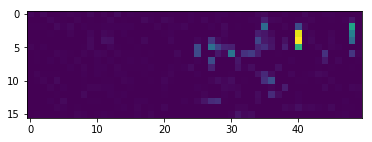

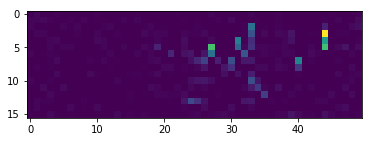

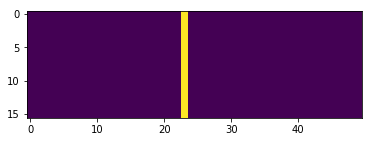

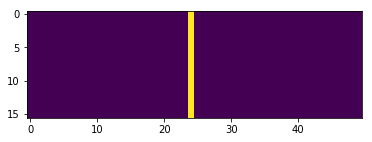

0.494087
0.4734375


In [192]:
#  test some frames
i = 600

plt.imshow(chron_X[i,0,:,:])
plt.show()

plt.imshow(chron_X[i,1,:,:])
plt.show()

correct_output = np.zeros(chron_X[i,0,:,:].shape)
correct_output[:,int(correct_output.shape[1]*chron_y[i])] = 1

plt.imshow(correct_output)
plt.show()


prediction = chron_model.predict(add_1( add_1( chron_X[i]), True) )[0][0]

predict_output = np.zeros(chron_X[i,0,:,:].shape)
predict_output[:,int(correct_output.shape[1]*prediction)] = 1

plt.imshow(predict_output)
plt.show()

print(prediction)
print(chron_y[i])

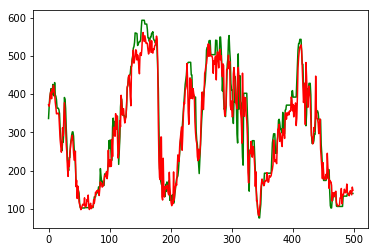

In [182]:
plt.plot(outputs[:500], c='g')
plt.plot(chron_model.predict(add_1( chron_X[:500]) )*640, c='r')
plt.show()

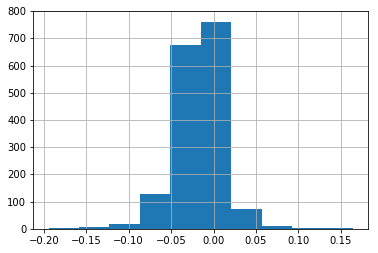

In [180]:
residals = (chron_model.predict(add_1(X_train)) - add_1(y_train))[:,0]

pd.Series(residals).hist()

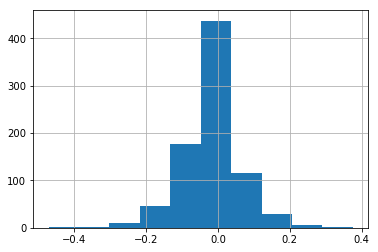

In [179]:
residals = (chron_model.predict(add_1(X_test)) - add_1(y_test))[:,0]

pd.Series(residals).hist()